# Exploratory Data Analysis

## Music Style Classification

In this notebook I'm analyzing the results of the models classifying mood, style, and genres in the music.

All of the models featured in this notebook were trained on 1280-dim embeddings produced by the [discogs-effnet model](https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.json)

In [28]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 100)
plt.style.use("ggplot")

In [29]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [30]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [31]:
#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

I'll be analyzing data from the following tables

In [32]:
tables = ['approachability_2c_effnet_discogs_1_activations',
 'danceability_effnet_discogs_1_activations',
 'engagement_2c_effnet_discogs_1_activations',
 'mood_acoustic_effnet_discogs_1_activations',
 'mood_aggressive_effnet_discogs_1_activations',
 'mood_happy_effnet_discogs_1_activations',
 'mood_party_effnet_discogs_1_activations',
 'mood_sad_effnet_discogs_1_activations']

Load in tags data 

In [33]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head(5)

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit)_PN.wav,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit),Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN.wav,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [34]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3730 entries, b806881a54bdbf9dd93a290716adf191 to aacd98f09aa0570903ff541085e98a66
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      3730 non-null   float64
 1   gain        3730 non-null   float64
 2   codec       3730 non-null   object 
 3   file_name   3730 non-null   object 
 4   bpm         3332 non-null   float64
 5   initialkey  2793 non-null   object 
 6   title       3653 non-null   object 
 7   album       1569 non-null   object 
 8   artist      2732 non-null   object 
 9   date        1121 non-null   object 
 10  genre       333 non-null    object 
 11  label       188 non-null    object 
dtypes: float64(3), object(9)
memory usage: 378.8+ KB


### Ear Test

Similar to the EDA Effnet Genres notebook, I'll be evaluating the models' performance in appraising my song collection based on their models. I'm especially curious to see their scores because mood scores are arguably more useful to me as a DJ. When I curate tracks for a gig, I need to assemble a collection of songs that match the "vibe" of the event. I don't drop brash techno at a winebar nor would I play somber r'nb at a night club.

Assuming these metrics are fairly workable, I envision using them as a way to conditionally filter songs for gigs; think writing a query for a night club gig that's like 

>`SELECT songs FROM tbl where dance_score >threshold and engagement_score < threshold2`


Another thing I'm curious about is that labels such as approachablility, engagement, and sadness in the context of music are much more abstract concepts than genre. In most cases, a song's genre is solid but how do you define how "approachable" a song is? Even something obvious like "danceability" poses its own unique challenges, how can a model get a grasp of how danceable a song is when significantly different genres of music can all be considered highly danceable.

With those and other questions in mind, I'll go through each of the mood/style tables and assess the model ratings.

**Activation DataHub Class**

I'm creating a class that holds all the methods and data that I'll be repeatedly working with for each of the activation scores tables. 

For each mood/style table I will:
    
- Create a `ActivationDataHub` object. 
    
- Call the `dist_viz` method visualize the distribution of ratings.
    
- Call `top_songs` to show the n number of songs with the highest or lowest ratings.
    
- Call `song_sampler` to randomly disply n number of songs with a score between a given interval.

In [35]:
class ActivationDataHub:
    
    def __init__(self, table_name):
        
        print(f"Loading {table_name} data")
        self.table_name = table_name
        self.df = pd.read_sql_query(f"SELECT * FROM {self.table_name}",con = conn).set_index("sid").applymap(lambda x:x[0])
        
        cols = self.df.columns
        
        self.col = cols[~cols.str.startswith("no")][0]
        self.scores = self.df[self.col]
        self.mean_scores = self.scores.apply(lambda x:x.mean())
        self.std_scores = self.scores.apply(lambda x:x.std())
        
        
    def dist_viz(self, figsize = (8, 5)):
        """
        This function shows a histogram of the average activation scores for a specified column 
        along with the summary statistics.
        """
        plt.figure(figsize = figsize)
        series = self.mean_scores
        ax = sb.histplot(x= series)
        ax.set_title(f"Distribution of {series.name.title()} Scores", fontsize = 18)
        ax.set_ylabel("Frequency", fontsize = 14)
        ax.set_xlabel(series.name.title() + " scores".title(), fontsize = 14)
        sum_stats = series.describe().round(3).__str__()
        sum_stats = "Summary Stats: \n"+ sum_stats[sum_stats.find("\n"):sum_stats.find("\nName")]
        ax.annotate(sum_stats, (1.1,150), annotation_clip=False, fontsize= 14);
        
    def top_songs(self, n = 10, ascending = False):
        
        """
        Returns the n number of songs with the highest or lowest scores.
        """
        series = self.mean_scores
        
        if ascending:
            top_scores = series.nsmallest(n)
        else:
            top_scores = series.nlargest(n)
        return pd.concat([tags, top_scores], 
                         axis = 1).dropna(subset=[series.name])[["title",
                                                                "artist", series.name]].sort_values(by = series.name,
                                                                                            ascending=ascending).round(4)
    
    def song_sampler(self, window, n = 10, rs = 1):
        """
        Returns a sample of songs with a score between the provided window. 
        Includes mean score and standard deviation of scores.
        
        """
        
        l,r = window
        mean_series = self.mean_scores.rename("mean scores")
        std_series = self.std_scores.rename("stdev scores")
        
        mean_series = mean_series[(mean_series>= l) & (mean_series< r)]
        
        if n < mean_series.shape[0]:
            mean_series = mean_series.sample(n = n, random_state = rs)
        
        std_series = std_series.loc[mean_series.index]
        
        return pd.concat([tags, mean_series, std_series], 
                         axis = 1, join = "inner")[["title", "artist", mean_series.name, std_series.name]].round(4).sort_values("mean scores", ascending =False)

**Approachability**

"Music approachability predicting whether the music is likely to be accessible for the general public (e.g., belonging to common mainstream music genres vs. niche and experimental genres)."

More info ==> https://essentia.upf.edu/models.html#approachability


I'm the first to admit that the music I play is not mainstream — you won't hear any Taylor Swift/Drake mashups at my sets.

With that being said I'm quite eager to know the approachability model's assessment of my collection. What does it mean if a song that is not popular is rated high on the approachability scale? This could potentially be a huge deal because DJs love to play great songs that crowds haven't heard before. So if I have a bunch relatively obscure songs whose sound has massive crossover appeal, I could be onto something here.

In [36]:
table = tables[0]
approach = ActivationDataHub(table_name=table)
approach.df.head()

Loading approachability_2c_effnet_discogs_1_activations data


,not_approachable,approachable
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.7773523, 0.8477703, 0.74907845, 0.86111253, 0.7850447, 0.8689087, 0.71038795, 0.81490517, 0.5...","[0.22264773, 0.15222974, 0.25092158, 0.13888745, 0.21495527, 0.13109131, 0.2896121, 0.18509479, ..."
46e54d2ab920a088b77382e04877141b,"[0.9233631, 0.94062567, 0.9361475, 0.9502406, 0.95356244, 0.9412267, 0.94867647, 0.9170702, 0.94...","[0.0766369, 0.059374325, 0.06385247, 0.049759354, 0.0464376, 0.058773216, 0.05132359, 0.08292975..."
a204ddef5763df6d8f7677701fe9d96f,"[0.31597278, 0.44296739, 0.37413007, 0.3979797, 0.36894128, 0.41880748, 0.30266258, 0.35461393, ...","[0.6840272, 0.5570327, 0.6258699, 0.60202026, 0.6310587, 0.5811925, 0.69733745, 0.64538604, 0.67..."
960097894e83c5810a9c649f17a4e551,"[0.4144781, 0.3078609, 0.43320435, 0.2669011, 0.36961454, 0.2960183, 0.3229168, 0.25113502, 0.13...","[0.5855219, 0.6921391, 0.5667957, 0.733099, 0.6303855, 0.7039817, 0.6770832, 0.74886495, 0.86378..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.828504, 0.7391437, 0.66389257, 0.82320875, 0.71819824, 0.7778949, 0.67318004, 0.8050778, 0.64...","[0.17149605, 0.26085627, 0.33610743, 0.17679125, 0.28180176, 0.22210509, 0.32681996, 0.19492222,..."


In [37]:
song1 = approach.df.iloc[0]
song1

not_approachable    [0.7773523, 0.8477703, 0.74907845, 0.86111253, 0.7850447, 0.8689087, 0.71038795, 0.81490517, 0.5...
approachable        [0.22264773, 0.15222974, 0.25092158, 0.13888745, 0.21495527, 0.13109131, 0.2896121, 0.18509479, ...
Name: b806881a54bdbf9dd93a290716adf191, dtype: object

In [38]:
song1.apply(len)

not_approachable    140
approachable        140
Name: b806881a54bdbf9dd93a290716adf191, dtype: int64

As seen in the EDA Effnet Genres notebook, the data in this and the ensuing tables possess the same structure. Each cell in the pandas dataframe is a N-length array holding the activation scores for the class mentioned in the column name.

In [39]:
def pair_sum(x, col1, col2):
    #Grab the arrays from both columns
    data1 = x[col1]
    data2 = x[col2]
    #Add them together
    summ = data1+data2
    
    #calculate the mean and if the mean is close to 1 then it indicates they basically sum to 1
    return summ.mean()

In [40]:
approach.df.apply(lambda x:pair_sum(x, 'not_approachable', 'approachable'), axis = 1).value_counts()

1.0    3732
dtype: int64

I'm repeating a task I did in the Effnet Genres notebook by comparing the means and standard deviations in order to see how representative a mean is of a whole array.

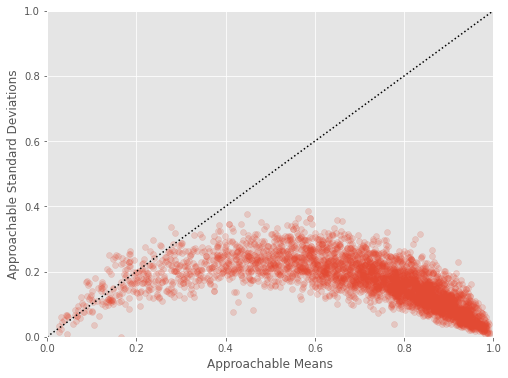

In [41]:
approach_df_mean = approach.mean_scores
approach_df_std = approach.std_scores
plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(approach_df_mean, approach_df_std, alpha = .2)
plt.plot([0, 1],":", c= "black" )
plt.xlabel("Approachable Means")
plt.ylabel("Approachable Standard Deviations");

For the most part, the means greater than the standard deviations which fills me with more confidence when interpreting analysis made on the means.

**Summary Stats and Distribution**

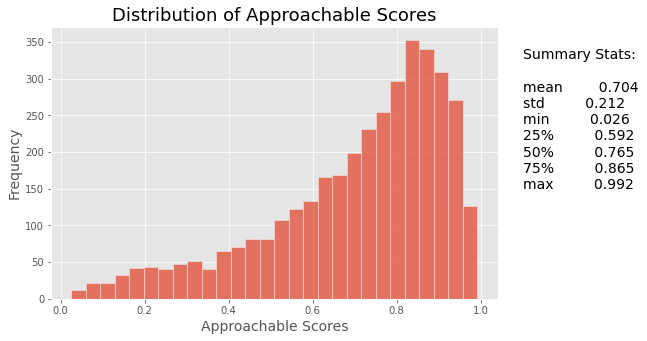

In [42]:
approach.dist_viz()

Given what I wrote earlier, this chart is quite surprising. It indicates that this model highly rates my music collection how accessible it is to the public. 

Now let's take a look at the five most and least approachable songs in the database.

In [43]:
approach.top_songs(n = 5)

,title,artist,approachable
sid,,,
bd8fba4e12551113b6bb28e30659cad3,I Love You (Extended),Karriem,0.9923
1b8532b6d23301b8ea16d82d7c33cba3,ouiness_zina_finished!,None,0.9890
c1becbc465751149b42ad8ebbe06d80c,"Şehrazat - Kendim ettim, kendim buldum (disco funk, Turkey 1981)",ultradiskopanorama,0.9889
b6f5a4b06bbd4279f4e8727a137bfe7f,Don't Let Me Down,Marcia Griffiths,0.9887
e68b85b8da0842ca44ad583b4d5cebea,Mioukouna,NST Cophie's,0.9887


My initial reaction here is skepticism. The songs listed above in the dataframe are certainly not the first songs in my catalog that I would nominate for approachability.

Have a listen and judge for yourself.

1. [I Love You (Extended) - Karriem](https://www.youtube.com/watch?v=kMpdZAuZu7M)

2. [Ouiness - Zina](https://www.youtube.com/watch?v=XIvIjTA1L_E)

3. [Kendim ettim, kendim buldum - Sehrazat](https://www.youtube.com/watch?v=UdICW7YqaoU)

4. [Don't Let Me Down - Marcia Griffiths](https://www.youtube.com/watch?v=dtpDmZpjsJE)

5. [Mioukouna -  N.S.T Cophie's](https://www.youtube.com/watch?v=vnfznqH7vQw)

I am perplexed when these songs made the top 5. At least of these tracks I wouldn't play in a typical gig, I'd only play them for a crowd I'm confident will appreciate relative obscure music.

Now let's look at the other side of the spectrum and see how the "unapproachable" songs stack up

In [44]:
approach.top_songs(ascending=True, n = 5)

,title,artist,approachable
sid,,,
67a5a54a5f62b597509e9d97eae584b3,Extra Vergine,Maus & Stolle,0.0259
7beef7d719bc71b16439eadc452152da,Matter Of Time (Vamos Mix),MRD,0.0268
a5e390371b3438d58800a9e8fa0332a1,Everybody,DISAIA,0.0315
b6b676e68093434e6c1e0e569b3dfdae,Voodoo Ray (Hey Dan Edit)_PN,A Guy Called Gerald,0.0316
f586f46de0a2df993f5823c2ccad4f96,Maurice - This is Acid (Sportello TB303 Edit),Sportello,0.0341


1. [Extra Vergine - Maus & Stolle](https://www.youtube.com/watch?v=ykOCriwIatc)

2. [Matter of Time (Vamos Mix) - MRD](https://mrdof1988.bandcamp.com/track/matter-of-time-vamos-mix)

3. [Everybody - DISAIA](https://www.youtube.com/watch?v=Z61TYWLGbck)

4. [Voodoo Ray (Hey Dan Edit) - A Guy Called Gerald](https://www.youtube.com/watch?v=clsB4bISUjc)

5. [This is Acid (Sportello TB303 Edit) - Maurice](https://sportellomusic.bandcamp.com/track/maurice-this-is-acid-sportello-tb303-edit)


There is a stark difference between the bottom and top sets of songs. The bottom ten are or similar to deep house and techno and are the type of songs soundtracking a stoic-faced audience. Whereas the top 5 songs are all funky and percolating buoyant and jovial vibes. 

Comparing the two sets of songs was helpful in advancing my understanding of how this model interprets approachability.

Most importantly I can definitely see myself using this metric in curating a set list.

**Middle sample**

To get a better understanding of approachability, let's sample five songs from with scores in between 0.6 and 0.8.

In [49]:
approach.song_sampler(window = (.6, .8), n = 5, rs = 4)

,title,artist,mean scores,stdev scores
sid,,,,
06b08b5a5905ac885bfe3ac2ebeddf61,I Can't Wait (Nudisco Clubmix)_PN,"Block & Crown, Denise Brown",0.7819,0.1895
7cb559c83eb8972694024ba978a81003,Kiki Gyan - Disco Train (Judge Funk DJ Edit),Judge Funk,0.7433,0.2114
fc8c80a17f16e951ef2c4eedd8f1dffa,Livy Ekemezie - Holiday Action (ANDYS Edit) (best holiday),ANDYS,0.6949,0.1958
14dba487dbf35da6ca23d212fc728e0f,Soul Makossa (Money) (UK Radio Edit),YOLANDA BE COOL,0.6730,0.2360
4849868c26658cd6ee6748100099ba0c,Kitchen Ninja (Master),Igor Gonya,0.6623,0.1882


1. [I Can't Wait (Nudisco Clubmix)_PN	Block & Crown, Denise Brown](https://www.beatport.com/release/i-cant-wait-nudisco-2021-mix/3434733)

2. [Kiki Gyan - Disco Train (Judge Funk DJ Edit)	Judge Funk	](https://www.youtube.com/watch?v=ZRprQUHsx_g&ab_channel=SoundwayRecords)

3. [Livy Ekemezie - Holiday Action (ANDYS Edit) (best holiday)	ANDYS](https://soundcloud.com/hey_andys/livy-ekemezie-holiday-action)

4. [Soul Makossa (Money) (UK Radio Edit)	YOLANDA BE COOL](https://soundcloud.com/yolandabecool/soul-makossa-money-yolanda-be-cool-dcup)

5. [Kitchen Ninja (Master)	Igor Gonya](https://www.youtube.com/watch?v=KVvwkVupgKo&ab_channel=Gazzz696)

My general feeling is that all 5 songs deserved to be rated higher on the approachability scale. My guess is that while large sections in the songs do sound very approachable, their scores are depressed by occasional low approachable periods. 

I include the standard deviations to provide some context on how representative the mean score is of the entire song. For instance, Soul Makossa has a relatively high standard deviation of its approachability scores, indicating significant flucatuations in that score over the course of that song.

**Danceability**

Pretty obvious definition here. However I am curious to see if genre influences the danceability scores. Does the model rate a funk/soul song at the same danceability level as a house song. 

More info ==> https://essentia.upf.edu/models.html#danceability


In [50]:
table = tables[1]
dance = ActivationDataHub(table_name=table)
dance.df.head()

Loading danceability_effnet_discogs_1_activations data


,danceable,not_danceable
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.9999424, 0.99976045, 0.99983895, 0.999848, 0.9999571, 0.9998455, 0.99988437, 0.9999192, 0.999...","[5.7582864e-05, 0.00023951827, 0.00016103889, 0.00015194346, 4.2891123e-05, 0.0001544856, 0.0001..."
46e54d2ab920a088b77382e04877141b,"[0.9999032, 0.9998369, 0.9999192, 0.99990785, 0.999863, 0.9996996, 0.99984634, 0.9998692, 0.9999...","[9.678665e-05, 0.0001630632, 8.081043e-05, 9.213655e-05, 0.00013701127, 0.000300486, 0.000153600..."
a204ddef5763df6d8f7677701fe9d96f,"[0.9981535, 0.9973373, 0.99670726, 0.99800974, 0.99799085, 0.99702066, 0.9951497, 0.99816823, 0....","[0.0018464968, 0.0026626734, 0.0032927275, 0.0019902333, 0.0020091475, 0.0029792786, 0.004850342..."
960097894e83c5810a9c649f17a4e551,"[0.999871, 0.9997358, 0.9998858, 0.99950945, 0.99984443, 0.9997348, 0.99975425, 0.9996364, 0.999...","[0.00012900884, 0.00026420056, 0.00011422723, 0.0004905543, 0.0001555365, 0.00026516986, 0.00024..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.69107103, 0.6084443, 0.5064755, 0.8155328, 0.6933056, 0.7086905, 0.43645376, 0.90993106, 0.90...","[0.30892897, 0.39155573, 0.49352455, 0.18446714, 0.3066944, 0.29130954, 0.56354624, 0.090068914,..."


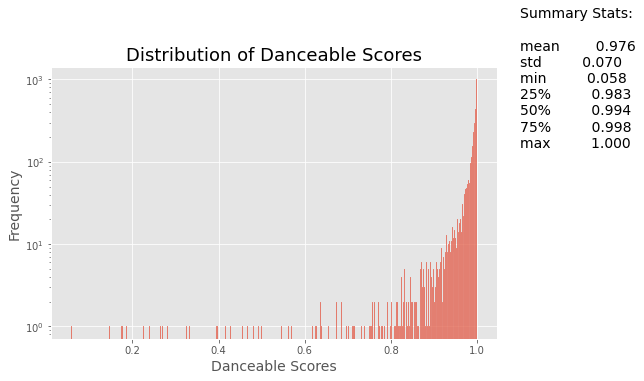

In [275]:
dance.dist_viz()
plt.yscale("log")

Not a big surprise that nearly every song in the database is rated highly on the danceability scale.

In fact, only 2% of songs have danceability scores lower than 0.8

In [70]:
np.mean(dance.df_mean.danceable<.8)

0.01985854189336235

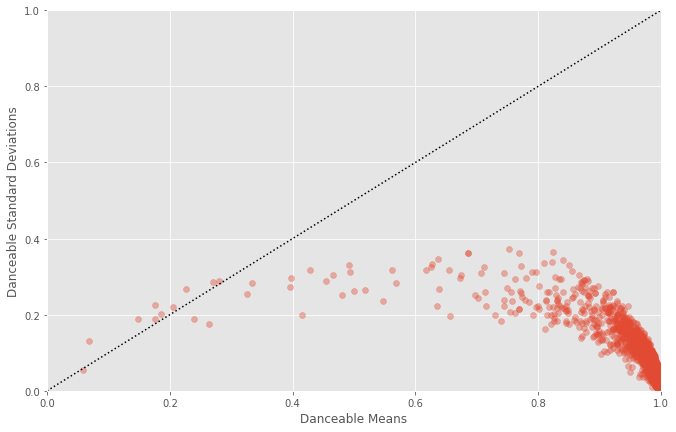

In [276]:
plt.figure(figsize=(11, 7))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(dance.mean_scores, dance.std_scores, alpha=.4)
plt.plot([0, 1],":", c= "black" )
plt.xlabel("Danceable Means")
plt.ylabel("Danceable Standard Deviations");

It's not worth showing the top danceable songs because it doesn't reveal anything new. However let's see what lies on the other side of the spectrum.

In [277]:
dance.top_songs(ascending=True, n = 5)

,title,artist,danceable
sid,,,
742d1fc3a38304122239d07244e0106e,Ende Beerabeero Rare Unknown Ethiopian Disco Modern Soul 45-785Pujxp7rU,Habte Awalom,0.0582
cea0eaff11847df1ef9fd641977527df,Mazhar Ve Fuat - Adimiz Miskindir Bizim (Mark Wayward Edit),Mark Wayward,0.0691
d7bfc278db4dbabfd1659252247c8899,J.J. Cale - RSDD003 - Social Distance Edits - 05 Lies (Mr. PC Belle Isle Balearic 12- Edit),None,0.1475
9aa0080ebc4cde62f3136f9786cdb7c3,Wede Harer Guzo,Hailu Mergia,0.1755
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.1760


1. [Endebeerabeero - Habte Awalom](https://www.youtube.com/watch?v=785Pujxp7rU&ab_channel=JointCustody)

2. [Mazhar Ve Fuat Adimiz Miskindir Bizim (Mark Wayward Edit) - Mark Wayward](https://soundcloud.com/mark-wayward/mazhar-ve-fuat-adimiz-miskindir-bizim-mark-wayward-edit)

3. [J.J. Cale - RSDD003 - Social Distance Edits - 05 Lies (Mr. PC Belle Isle Balearic 12- Edit)	](https://petercroce.bandcamp.com/track/lies-mr-pc-belle-isle-balearic-12-edit)

4. [Wede Harer Guzo - Hailu Mergia](https://www.youtube.com/watch?v=wU_gcM7lmD8&ab_channel=AwesomeTapesFromAfrica)

5. [Lord Have Mercy - The Lijadu Sisters](https://www.youtube.com/watch?v=cYDwE9yFB_I&ab_channel=TheLijaduSisters-Topic)

For the most part, I agree with these assessments. These songs certainly won't bring the house down. I do feel like Endebeerabeero could be rated somewhat higher, but overall no issues with this data.

**Middle Sample**

5 randomly sampled songs with danceability scores between 0.75 and 0.85

In [282]:
dance.song_sampler((.75, .85), n = 5)

,title,artist,mean scores,stdev scores
sid,,,,
dbc7bbc0d7afb3cba4fa0fb26fa4ef1f,Charles Atangana & Emitais: Onguindo ( Tahira Edit),Various Artists,0.8389,0.2171
50345b72d25e46fc48595bac3111f32a,Nermin Niazi - Feisal Mosleh - Moving Still - Disco Se Aagay- Edits and Reprises - 03 Dekha Jab ...,None,0.8327,0.2276
5658412c83cd9fc3ff53eb115c97ec90,Du Går Du Kommer (Disco Tech Edit)_PN,None,0.8019,0.2766
b085951a81e3078f4b114d1ffc5e80b5,The Boogashake,MARIO ALLISON Y SU COMBO,0.8011,0.2158
b339410d53da91722c38f1e2e769f87f,Hugo Blanco - Guajira Con Arpa,None,0.7797,0.2973


1. [Charles Atangana & Emitais: Onguindo ( Tahira Edit)	](https://www.youtube.com/watch?v=jaucVs847EU&ab_channel=AudioFalante)

2. [Nermin Niazi - Feisal Mosleh - Moving Still - Disco Se Aagay- Edits and Reprises - 03 Dekha Jab Se Dekha](https://discostan.bandcamp.com/track/dekha-jab-se-dekha)

3. [Du Går Du Kommer (Disco Tech Edit)](https://soundcloud.com/disco-tech-edits/du-gar-du-kommer-disco-tech-edit)

4. [The Boogashake - Mario Allison Y SU Combo](https://vampisoul.bandcamp.com/track/the-boogashake)

5. [Hugo Blanco - Guajira Con Arpa](https://www.youtube.com/watch?v=NDixCSR5AvA&ab_channel=PatrickLatinJazzBoogalooFunkSoul)

Hard to make an assessment here. I find these songs fairly danceable but I probably won't play them at a dance party.

### Engagement

Music engagement predicting whether the music evokes active attention of the listener (high-engagement “lean forward” active listening vs. low-engagement “lean back” background listening).

More info => https://essentia.upf.edu/models.html#engagement

I have high hopes for this metric because of the simple reason that a good DJ plays "engaging" music. A key skill in DJing is assessing the energy level of their gigs. The engagement metric could be a useful proxy for energy. If I am playing a chiller, lowkey set then I could use engagement to help me assemble the right playlist of songs.

In [51]:
table = tables[2]
engage = ActivationDataHub(table_name=table)
engage.df.head()

Loading engagement_2c_effnet_discogs_1_activations data


,not_engaging,engaging
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.01610879, 0.03347205, 0.03819201, 0.0459898, 0.011230065, 0.029323494, 0.026065817, 0.0204776...","[0.9838912, 0.96652794, 0.96180797, 0.9540102, 0.9887699, 0.97067654, 0.9739342, 0.97952235, 0.9..."
46e54d2ab920a088b77382e04877141b,"[0.0025433216, 0.0068556145, 0.002352924, 0.0066941506, 0.0029510593, 0.012337105, 0.0041766968,...","[0.9974567, 0.9931444, 0.9976471, 0.99330586, 0.9970489, 0.98766285, 0.99582326, 0.9943621, 0.99..."
a204ddef5763df6d8f7677701fe9d96f,"[0.009494705, 0.025756417, 0.012806551, 0.021973863, 0.010267618, 0.02111152, 0.010153408, 0.018...","[0.9905053, 0.9742435, 0.9871934, 0.9780261, 0.9897323, 0.97888845, 0.9898465, 0.98158735, 0.986..."
960097894e83c5810a9c649f17a4e551,"[0.00086885516, 0.00088291627, 0.0010570403, 0.00079634396, 0.001559757, 0.0007735467, 0.0013624...","[0.99913114, 0.9991171, 0.99894303, 0.9992036, 0.9984402, 0.99922645, 0.9986375, 0.99925584, 0.9..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.59090894, 0.7070218, 0.62421054, 0.6648362, 0.5044175, 0.6665438, 0.67336226, 0.61193955, 0.5...","[0.40909111, 0.29297823, 0.37578952, 0.33516386, 0.49558252, 0.33345625, 0.3266378, 0.3880605, 0..."


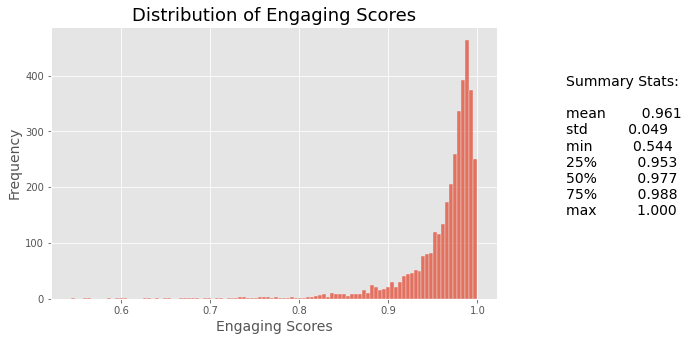

In [284]:
engage.dist_viz()

**Good news!**

Essentia's music engagement model thinks I am an engaging DJ. The vast majority of my songs have an average engaging score of greater than or equal to 0.9.

**Top 5 Engaging songs**

In [285]:
engage.top_songs(ascending=False, n = 5)

,title,artist,engaging
sid,,,
681ccf47549a629028cf97f8a816cfd7,Happy Song (Club Mix),Boney M,0.9997
0074bca61fc9947f1aae555d7f694139,Tchamy Patterson - First Man for Cry,reclusiv recordings,0.9996
bd8fba4e12551113b6bb28e30659cad3,I Love You (Extended),Karriem,0.9996
9124ded476f1e811c6b59b14a6d13bf5,"All My Life (12"" Funk 1983)",Major Harris,0.9995
138d96f7557b5abcc0483469f9f78b6e,DiscoGram - DG006 - 01 Dancing!_PN,None,0.9995


1. [Happy Song (Club Mix) - Boney M](https://www.youtube.com/watch?v=0_wf30gK9Pg&ab_channel=style300x)

2. [Tchamy Patterson - First Man for Cry - reclusiv recordings](https://www.youtube.com/watch?v=MAbUpL2bw08&ab_channel=LaboratoireTchamyPATTERSON)

3. [I Love You (Extended) - Karriem](https://www.youtube.com/watch?v=37sMZVsSxTs&ab_channel=FavoriteRecordings)

4. [All My Life (12" Funk 1983) - Major Harris](https://www.youtube.com/watch?v=qpcqQ8ifpRc&ab_channel=CoolfunkZ%C3%A9z%C3%A92)

5. [DiscoGram - DG006 - 01 Dancing!](https://www.youtube.com/watch?v=UvEZ1tQywTs&ab_channel=Funk%27nDisco%26Stuff)

The model isn't wrong here hand out high engagement appraisals for these five songs. What I am curious about is that the >0.999 mean engaging scores indicate that the model rates every section of each song as engaging.

**Bottom 5 engaging songs**

In [286]:
engage.top_songs(ascending=True, n = 5)

,title,artist,engaging
sid,,,
b85f2a4c63f48e712284262c7ff6ffbd,Automation - Workings Of A Madman Re-Mix,Tiny Magnetic Pets,0.5439
ed91d262dc3a679bac460f2f1d8b78ff,King Crimson - RSDD003 - Social Distance Edits - 11 The Sheltering Sky (Mr. PC Belle Isle Balear...,None,0.5578
9b69b0c8d5fdeee9e6950481d0caa1f1,Bubuj Bulan,Rully Djohan,0.5625
d71d4a7afde1a9891e56fe0fdf307aff,Azara alhai,Rasha,0.5869
540f1f587d15e9edc9ff5a2d82ab021b,Luiz Enrique - Mas Que Nada (Brasileiro Rework),Sonic Funk Foundry,0.5884


1. [Automation - Workings Of A Madman Re-Mix	Tiny Magnetic Pet](https://www.youtube.com/watch?v=X4I4LU04iCo&ab_channel=TinyMagneticPets-Topic)

2. [King Crimson - RSDD003 - Social Distance Edits - 11 The Sheltering Sky (Mr. PC Belle Isle Balear.](https://www.youtube.com/watch?v=ikYm6Y8u6eU&ab_channel=KingCrimson)

3. [Bubuj Bulan	Rully Djohan](https://www.youtube.com/watch?v=3a5IpOR24PQ&ab_channel=SoundwayRecords)

4. [Azara alhai	Rasha](https://www.youtube.com/watch?v=WOdcgc9ot3k&ab_channel=ZicZakGarage)

5. [Luiz Enrique - Mas Que Nada (Brasileiro Rework)	Sonic Funk Foundry](https://sonicfunkfoundry.bandcamp.com/track/luiz-enrique-mas-que-nada-brasileiro-rework)

This result confirms my hypothesis that engagement can be proxy a for energy (or at the very least correlates with it.)

All five of these songs are low-energy and are more appropriate for dinner parties than any gig I usually play.

**Engagement sampling**

Five randomly songs with engagement scores between 0.6 and 0.8

In [287]:
engage.song_sampler((.6, .8), n = 5)

,title,artist,mean scores,stdev scores
sid,,,,
97e612c4adfaaa9ac1b974090987a4e9,Vera o Carioca (Carimboogie Edit),Tim Maia,0.7733,0.1752
904bd348ce46ccf7f7c5e94224a985b0,Pleasure of Love - Nala - Tijan,None,0.7630,0.1504
0fb06c1214498205667582c3a28b21d8,Distant Love,Yung Bae,0.7222,0.1206
49ed8ada9126c2b70dc34f95de3b8d89,Uppers Chapter 2 - Samarin Bolga ( Kill Emil Edit ),Kill Emil,0.7207,0.1555
9096df0bc4ec9fc1610251daa8718700,Musow,Neba Solo,0.6918,0.1865


1. [Vera o Carioca (Carimboogie Edit)	Tim Maia](https://tropicanarecords.bandcamp.com/track/tim-maia-ver-o-carioca-carimboogie-edit)


2. [Pleasure of Love - Nala - Tijan	](https://soundcloud.com/pleasureoflove-la/13-nala-tijan)


3. [Distant Love	Yung Bae](https://www.youtube.com/watch?v=kJDg19Oa9EM&ab_channel=MarsThe3)

4. [Uppers Chapter 2 - Samarin Bolga ( Kill Emil Edit )	Kill Emil](https://soundcloud.com/killemilmusic/uppers-chapter-2-samarin-bolga)

5. [Musow - Neba Solo](https://secousse.bandcamp.com/track/musow)

### Danceability vs Engagement

Danceability and engagement appear to be strongly correlated (not entirely surprising tbh) so let's dive into this relationship.

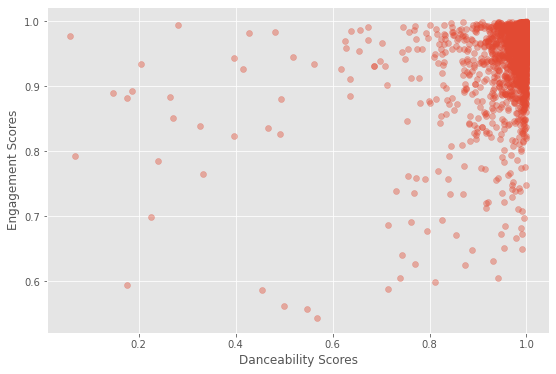

In [288]:
dance_means = dance.mean_scores
engage_means = engage.mean_scores
engage_dance = pd.concat([engage_means, dance_means], axis = 1)

plt.figure(figsize=(9, 6))
plt.scatter(engage_dance.danceable, engage_dance.engaging, alpha=.4)
plt.xlabel("Danceability Scores")
plt.ylabel("Engagement Scores");

Most of the songs are clustered in the top right corner, which tell us that engagement and danceability do indeed trend together.

89% of my songs have both danceable and engaging scores above or equal to 0.9

In [289]:
engage_dance.query("danceable >=.9 and engaging >=.9").shape[0]/engage_dance.shape[0]

0.8898858075040783

To learn how they differ from one another, I need to listen to high engaging/low danceable songs and low engaging/high danceable songs.

Here are songs with engaging scores >0.9 and danceable scores <0.5

In [290]:
high_engage_low_dance_songs = engage_dance.query("danceable <.5 and engaging >=.9")
tags.join(high_engage_low_dance_songs, how = "inner")[["title", "artist", "danceable", "engaging"]]

,title,artist,danceable,engaging
sid,,,,
f75e3622131ab738338fab375af88561,Amebo,The Lijadu Sisters,0.205313,0.934431
f34bbce6d615a660ef130647d9081d2c,I'M Feeling Sexy Tonight,Chona Cruz,0.481110,0.983108
49bb9fbb857a4d32f25227689fcf07fc,Won't Stop,DJ Snatch,0.428210,0.982285
ddf1c7208935bd59488b65b70bc4a432,Bi Kameleou,Volta Jazz,0.395995,0.943350
738ebd50ad5af9928b648385124ca9b3,16671686_Let_s Freak feat. Mr. V feat. Louie Vega_(Freak-A-Pella)_PN,None,0.414951,0.926072
742d1fc3a38304122239d07244e0106e,Ende Beerabeero Rare Unknown Ethiopian Disco Modern Soul 45-785Pujxp7rU,Habte Awalom,0.058170,0.977563
bcc2163e1ea5787c4d1f304607bd51ea,Disco Luismi (Edit de DiscoRollers)_PN,Various Artists,0.280143,0.993640


- [Amebo - The Lijadu Sisters](https://www.youtube.com/watch?v=-a3-mDAoNJM&pp=ygUUYW1lYm8gbGlqYWR1IHNpc3RlcnM%3D)

- [I'm Feeling Sexy Tonight - Chona Cruz](https://www.youtube.com/watch?v=RG57K_9y5Rc&ab_channel=Marc%27sOPMPlaylist)

- [Bi Kameleou - Volta Jazz](https://www.youtube.com/watch?v=tSOU38-0qsA&ab_channel=VoltaJazz-Topic)

- [Ende Beerabeero - Habte Awalom](https://www.youtube.com/watch?v=785Pujxp7rU&ab_channel=JointCustody)

- [Disco Luismi (Edit de DiscoRollers)](https://soundcloud.com/zhino/disco-luismi-discorollers)

It's correct to say that these songs won't make you bust a sweat on the dance floor but I can see why they're rate high on engaging. 

For example "I'm Feeling Sexy Tonight" showing up here makes sense because it's a slow-paced song yet incredibly fun song due to its catchy melody and hook. 

Now for high danceability and low engagement (danceable >.9 and engaging <.7)

In [291]:
low_engage_high_dance_songs = engage_dance.query("danceable >.9 and engaging <.7")
tags.join(low_engage_high_dance_songs, how = "inner")[["title", "artist", "danceable", "engaging"]]

,title,artist,danceable,engaging
sid,,,,
5b787eb97c0aeabca71a7a518ff5f57c,Marcos Valle - Água de Côco (Bernardo Pinheiro Edit),Bernardo Pinheiro,0.988168,0.681545
7b46a41051289c9bd3ae80d1eb0a788d,Bananeira da Ilha (cotait edit),África Tentação,0.977446,0.667144
f9a6e07d75b3f5c33db8f672b62d8401,Diálogo de Crioulos (Milton e Beto Chuquer Edit),None,0.931654,0.631613
31ab4708ffb4a57d52bac3613879cf22,Seven Windows - Danse Ralenti,reclusiv recordings,0.953039,0.651145
48c75551e75efc744602b9784bc10aeb,She,Those Guys From Athens,0.948289,0.673658
38e6a247694ad7cede598f46543107d0,Paperkraft - 私たちだけ何を話しているのか知っています。 - 04 B2. So deep in luv,None,0.990214,0.673340
c86eb429cf50cb8b138ac284b196c257,It's Music,Jex Opolis,0.991384,0.649430
5da5537a74d7311bec5964945d79db6b,Hashish (DJ Kobayashi Edit),Ibrahim Maalouf,0.994678,0.697119
1de80db15a46de00c6cbd06414e27b96,Bongosynth - Verão do Amor - 18 Gal Costa - A Mulher (De Sena Edit),None,0.940769,0.605812


- [Marcos Valle - Água de Côco (Bernardo Pinheiro Edit)](https://soundcloud.com/bernardopinheiro/marcos-valle-agua-de-coco-bernardo-pinheiro-edit)

- [Bananeira da Ilha (cotait edit)	África Tentação](https://rafaelcotait.bandcamp.com/track/frica-tenta-o-bananeira-da-ilha-cotait-edit)

- [Diálogo de Crioulos (Milton e Beto Chuquer Edit)](https://soundcloud.com/beto-chuquer/elza-soares-miltinho-e-som-tres-dialogo-de-crioulos-milton-e-beto-chuquer-edit)

- [Seven Windows - Danse Ralenti](https://www.youtube.com/watch?v=e_VXUX-kbVI&ab_channel=KeimiNewBeatCollector%2FOrgelAalst)

- [She	Those Guys From Athens](https://tooslowtodisco.bandcamp.com/track/she)

- [It's Music	Jex Opolis](https://www.youtube.com/watch?v=liBPbvUii0k&ab_channel=JexOpolis-Topic)

- [Hashish (DJ Kobayashi Edit)	Ibrahim Maalouf](https://djkobayashi.bandcamp.com/album/ibrahim-maalouf-hashish-dj-kobayashi-edit)

- [Bongosynth - Verão do Amor - 18 Gal Costa - A Mulher (De Sena Edit)](https://soundcloud.com/bongosynth/gal-costa-a-mulher-de-sena)

- [Lego Edit - Dancefloor Edits Afro Invasion - 05 The Trip (Lego Nu Edit Short Cut)](https://diegolellilegoedit.bandcamp.com/track/the-trip-lego-nu-edit-short-cut)

Based on this output, highly danceable and low engaging tracks are downtempo and lower energy. I don't really find these tracks all that danceable and they remind me lounge music.

### Acoustic music

More info => https://essentia.upf.edu/models.html#id459

I don't have any expectations here because "acoustic" is not a quality that factors significantly in a DJ's song selection. Nevertheless, I'm still curious to see how this model rates my song arsenal.

In [52]:
table_name = tables[3]
acoustic = ActivationDataHub(table_name=table_name)

Loading mood_acoustic_effnet_discogs_1_activations data


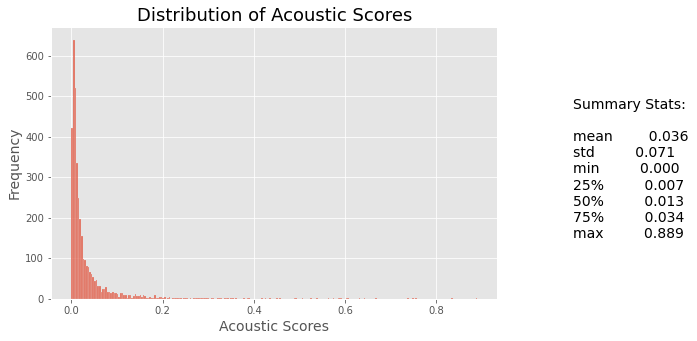

In [293]:
acoustic.dist_viz()

About as surprising as the danceability plot

Let's just look at the top 5 acoustic songs.

In [294]:
acoustic.top_songs(n= 5)

,title,artist,acoustic
sid,,,
d71d4a7afde1a9891e56fe0fdf307aff,Azara alhai,Rasha,0.8892
90c7378c60e273600d883d8b6cbab8a6,Telantena zare_PN,None,0.8327
cd54dcedd07842527ead1885aabf0e32,"Dhurata Dora -Ayo (Remix , Original Version) FULL VERSION",Culimusik,0.7566
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.7562
3da006514008184513b3a9af4ca1e559,De Noite Na Cama,Erasmo Carlos,0.7503


1. [Azara alhai	Rasha](https://www.youtube.com/watch?v=WOdcgc9ot3k&ab_channel=ZicZakGarage)

2. [Telantena zare](https://www.youtube.com/watch?v=cJjZDxONGt0&ab_channel=ethiomelaku2)

3. [Dhurata Dora - Ayo Remix](https://music.youtube.com/watch?v=pd_OZgsRSiY)

4. [Lord Have Mercy	The Lijadu Sisters](https://www.youtube.com/watch?v=2LOUSR7jk-k&ab_channel=TheLijaduSisters)

5. [De Noite Na Cama	Erasmo Carlos](https://www.youtube.com/watch?v=7ZZTn6Cs06Y&ab_channel=DaniloSousRodrigues)

Every song exept Ayo by Dhurata Dora squarely falls under the acoustic umbrella. I don't know how Ayo could be considered acoustic

**Random samples**

Five randomly sampled songs with acoustic scores between 0.1 and 0.3

In [295]:
acoustic.song_sampler((.1, .3),n = 5)

,title,artist,mean scores,stdev scores
sid,,,,
e80a28b1e75761ae2d3f087f5ab399c0,Benya Amanze,Pat Thomas & Ebo Taylor,0.2151,0.1807
2412ab041726afc18763c2a04203a134,Danger,The Lijadu Sisters,0.2052,0.2054
ace346409e20be5b640b48f3f7125a41,Filaou Bessame,Amadou & Mariam,0.2018,0.2130
c65104f2c9ee76e43c206391553843cd,Unofficial A,DJ KAOS,0.1407,0.1590
9122e63c370067b11f54bdaa334a793d,10 Tirsa Song (edit)_PN,None,0.1091,0.1421


1. [Benya Amanze	Pat Thomas & Ebo Taylor](https://www.youtube.com/watch?v=-z1eI9mr8Gg&ab_channel=PatThomas-Topic)

2. [Danger	The Lijadu Sisters](https://www.youtube.com/watch?v=5eekpw0Hh54&ab_channel=TheLijaduSisters-Topic)

3. [Filaou Bessame	Amadou & Mariam](https://www.youtube.com/watch?v=wv9BZhYCCbk&ab_channel=Amadou%26Mariam)

4. [Unofficial A - DJ KAOS](https://soundcloud.com/djkaosofficial/unofficial-a)

5. [10 Tirsa Song](https://www.youtube.com/watch?v=0WIaQsCneAo)

Not as much uncertainty here. I can live with the acoustic ratings for these songs.

### Aggressive

More info => https://essentia.upf.edu/models.html#id471

I'm not sure exactly sure how aggressive could be useful to me. Disco, boogie and house aren't really "aggressive" in the way that tech-house, techno, and dubstep are. 

In [53]:
table_name = tables[4]
agg = ActivationDataHub(table_name=table_name)

Loading mood_aggressive_effnet_discogs_1_activations data


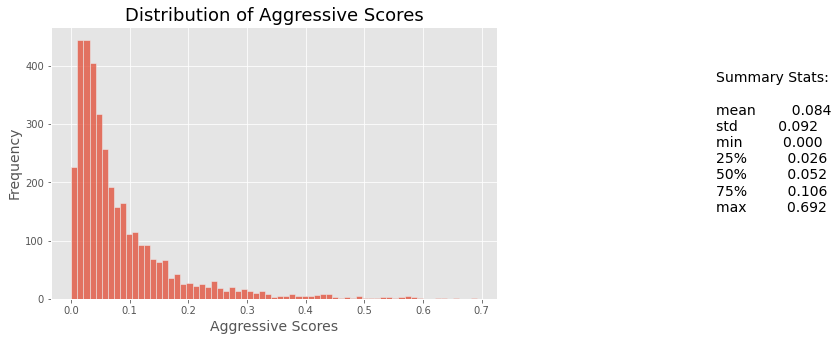

In [297]:
agg.dist_viz()

Not a whole lot of aggression present in my oeuvre.

What are the top 5 most aggressive songs?

In [298]:
agg.top_songs( n = 5)

,title,artist,aggressive
sid,,,
84e054c6294d8496a53dd81a6020b02d,Break,Nick Garcia,0.6925
c4c3b598c63b9de8950c44cacdfc20aa,Dino Soccio - Pleasure of Edits 07 - 03 Bump Theme (edit),None,0.6581
1ac21451b49daf78ed89a4d4774fe652,Lords Of The Future,Lords Of The Future,0.6542
01d99c36d2c6ff654e7833c3fc20a17b,Gil Dobrica - O Strada Mai Ingusta (Iorga Edit),IORGA,0.6327
8d594188e7461f1661e0c7c06693c75a,Spacer Woman (Roliva Edit),"Roliva, Charlie",0.6304


1. [Break - Nick Garcia](https://houseofboom.bandcamp.com/track/break)

2. [Dino Soccio - Pleasure of Edits 07 - 03 Bump Theme (edit)](https://dinosoccio.bandcamp.com/album/pleasure-of-edits-07)

3. [Lords Of The Future - Lords Of The Future](https://www.youtube.com/watch?v=jiUSAce3dXM&ab_channel=ElectronicLoveCollective)

4. [Gil Dobrica - O Strada Mai Ingusta (Iorga Edit)](https://iorga.bandcamp.com/track/gil-dobrica-o-strada-mai-ingusta-iorga-edit)

5. [Spacer Woman (Roliva Edit) - Roliva, Charlie](https://www.youtube.com/watch?v=xwk7rV-AUE0&ab_channel=DennisHultsch)

Based on this output, "aggressive" in the context of my song collection means electronic music with prominent synthy jabs and hits. "Break" and "Spacer Woman" are valid selections based on essentia's aggressive criteria.

**Random Samples**

Five randomly sampled songs with aggression scores between 0.2 and 0.4

In [300]:
agg.song_sampler((.2, .4), n = 5, rs = 2)

,title,artist,mean scores,stdev scores
sid,,,,
cb7ada4de074e01c17373dc800a6b588,Scoobs In Columbia (Ronny Hammond's Fania Love Retouche),Plaid,0.3923,0.2095
2c4aed24d9f749940b86bd247270ca8c,Selected Edits Vol 2 - 04 Abdul,Midnight Runners,0.3732,0.2264
89e44426f0ef38a867f5fc2534b3f7a2,Strike It Up_(Original Remix),Black Box,0.2354,0.1567
d6ec290df5a5aacb79394e80cbbc11dd,Musica Americana,Morlack,0.2328,0.2249
d3945a7dedfb8f8aa140134849558948,Going Home (Ilya Santana edit),ILYA SANTANA,0.2202,0.1565


1. [Scoobs In Columbia (Ronny Hammond's Fania Love Retouche)	Plaid	](https://soundcloud.com/ronny-hammond/plaid-scoobs-in-columbia-ronny-hammonds-fania-love-retouche)

2. [Selected Edits Vol 2 - 04 Abdul	Midnight Runners](https://midnightrunners.bandcamp.com/track/abdul)

3. [Strike It Up_(Original Remix)	Black Box](https://www.youtube.com/watch?v=Xo3kp5BLF6Q&ab_channel=BlackBoxHouse)

4. [Musica Americana	Morlack	](https://katakanaedits.bandcamp.com/track/musica-americana)

5. [Going Home (Ilya Santana edit)](https://www.beatport.com/track/going-home/14674365)

The randomly sampled songs helped solidify my understanding of how "aggression" is defined. I definitely hear aggressive elements in songs such as "Scoobs in Columbia" and "Strike it up"

### Happy

At a basic level, the metrics we've assessed so far adhere to a low energy-high energy spectrum. But sometimes energy isn't enough. Take for instance a sunny day party; that's is a scenario where both low energy and high energy songs can fit in. To me, what makes an appropriate day party song is how buoyant and uplifting it is. You wouldn't want to hear dour music a day party at the park or on a boat. 

That's where "happy" could possibly be of assistance. I could use this rating to select songs for more jovial occassions such as day parties. I think "happy" has the potential to add a critical and different dimension to low to high energy spectrum.

More info => https://essentia.upf.edu/models.html#id495

In [54]:
table_name = tables[5]
happy = ActivationDataHub(table_name)
happy.df.head()

Loading mood_happy_effnet_discogs_1_activations data


,happy,non_happy
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.36340898, 0.18219845, 0.3428177, 0.19498937, 0.39566082, 0.17289302, 0.40052393, 0.20453341, ...","[0.636591, 0.81780154, 0.6571822, 0.8050107, 0.60433924, 0.82710695, 0.599476, 0.7954666, 0.9311..."
46e54d2ab920a088b77382e04877141b,"[0.09185828, 0.08827926, 0.10759978, 0.09465805, 0.06764625, 0.08693469, 0.06990745, 0.15041173,...","[0.90814173, 0.9117208, 0.89240026, 0.905342, 0.9323538, 0.9130654, 0.9300926, 0.8495883, 0.9147..."
a204ddef5763df6d8f7677701fe9d96f,"[0.5078719, 0.3578924, 0.51367694, 0.39432797, 0.5174208, 0.41941053, 0.6050827, 0.44703227, 0.5...","[0.4921281, 0.6421076, 0.4863231, 0.60567206, 0.4825791, 0.58058953, 0.3949173, 0.5529677, 0.454..."
960097894e83c5810a9c649f17a4e551,"[0.8064001, 0.78968686, 0.8094659, 0.80943507, 0.8025667, 0.7954887, 0.79991245, 0.8111683, 0.73...","[0.19359986, 0.21031311, 0.19053414, 0.19056496, 0.19743326, 0.20451134, 0.20008764, 0.18883172,..."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.04381575, 0.05092577, 0.059241563, 0.054157313, 0.05069841, 0.03254329, 0.09770478, 0.0511871...","[0.9561842, 0.9490742, 0.94075847, 0.9458427, 0.9493016, 0.9674567, 0.90229523, 0.94881284, 0.90..."


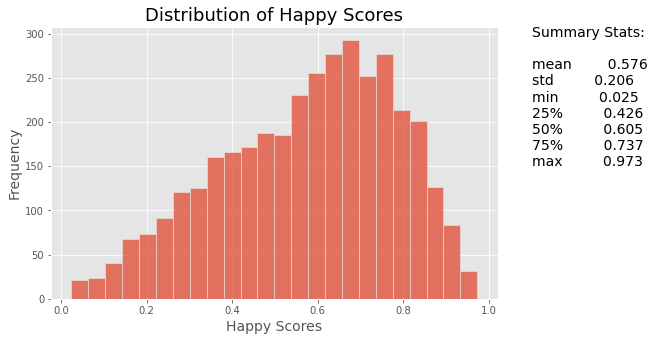

In [302]:
happy.dist_viz()

So far the closest distribution we've seen to a normal one and the closest 0.5.

The distribution feels right to me, I would've guessed that on average my songs are closer to totally happy than to totally not happy.

Top 5 happiest songs

In [303]:
happy.top_songs(5)

,title,artist,happy
sid,,,
b6f5a4b06bbd4279f4e8727a137bfe7f,Don't Let Me Down,Marcia Griffiths,0.9727
3746f02034387a50e5768211a47d055d,Act of Sedition - Tropical Punch - 03 The Peanut Man - DJ Laurel edit,None,0.9717
297a8b8f471264e63e8a67274e100782,Dance Motif - Stages (Dance Motif Edit),None,0.9682
b0be8c3bac085b48721c78a4940870cf,Harry Mwale — Pretty Face (Tambourine Party Edit)-YdrHvFAcPf8,None,0.9657
b085951a81e3078f4b114d1ffc5e80b5,The Boogashake,MARIO ALLISON Y SU COMBO,0.9651


1. [Don't Let Me Down - Marcia Griffiths](https://www.youtube.com/watch?v=dtpDmZpjsJE&ab_channel=JUNYAS-STEADY)

2. [Act of Sedition - Tropical Punch - 03 The Peanut Man - DJ Laurel edit](https://actofsedition.bandcamp.com/track/the-peanut-man)

3. [Dance Motif - Stages](https://soundcloud.com/dancemotif/stages-dance-motif-edit)

4. [Harry Mwale - Pretty Face(Tambourine Party Edit)](https://www.youtube.com/watch?v=YdrHvFAcPf8&ab_channel=DomGrooves)

5. [The Boogashake - Mario Allison Y SU Combo](https://vampisoul.bandcamp.com/track/the-boogashake)

I really had to sit and process this result. I definitely do feel that these five songs all have an upbeat, fuzzy, and jovial spirit to them. "The Boogashake" is certainely a song that qualifies as "happy". I think given the abstract nature of the model's task, it did a good job quantifying "happiness" in a song.

Top 5 least happy songs

In [304]:
happy.top_songs(ascending=True, n = 5)

,title,artist,happy
sid,,,
14265f14034ad61a32c3bff46ed0e476,9-Vicky_Montefusco_-_Il_Nulla_Cosmico_(Prins_Thomas_remix)_PN,None,0.0248
a5e390371b3438d58800a9e8fa0332a1,Everybody,DISAIA,0.0259
67a5a54a5f62b597509e9d97eae584b3,Extra Vergine,Maus & Stolle,0.0279
406de514de82d885a907e36adf681cc1,Insomnia 2022 (Extended Mix),"Flo Dosh, Faithless",0.0295
b85f2a4c63f48e712284262c7ff6ffbd,Automation - Workings Of A Madman Re-Mix,Tiny Magnetic Pets,0.0327


1. [Vicky_Montefusco_-_Il_Nulla_Cosmico_(Prins_Thomas_remix)](https://vickymontefusco.bandcamp.com/album/il-nulla-cosmico-prins-thomas-remix)

2. [Everybody	DISAIA](https://www.youtube.com/watch?v=Z61TYWLGbck&ab_channel=HotCreations)

3. [Extra Vergine	Maus & Stolle](https://www.youtube.com/watch?v=ykOCriwIatc&ab_channel=ThePanagoulis)

4. [Insomnia 2022 (Extended Mix)	Flo Dosh, Faithless](https://www.youtube.com/watch?v=pQgvls0JOXU&ab_channel=FloDosh)

5. [Automation - Workings Of A Madman Re-Mix	Tiny Magnetic Pets](https://open.spotify.com/track/4gkLGzGcspouro75i0T6EG)



According to this selection of songs, "unhappiness" comes in different forms. While these five all lack the jovial and upbeat qualities of the previous five, they vary in style and genre. The Vicky Montefusco track has a more industrial techno vibe pulsating with energy and Extra Vergine is a typical down tempo lounge house track that you'd hear in the background of a hotel bar.

**Randomly Sampled Songs**

In [305]:
happy.song_sampler((0.4, 0.7), n=5)

,title,artist,mean scores,stdev scores
sid,,,,
2d9b590d110e4de56f991d2aa8fe1d0b,In Case Of Emergency,Dr Packer & Loshmi,0.6961,0.1605
b9edcab845b4b340ef95951b0fa48553,Saturn Disco (original mix),Ezirk,0.6438,0.1497
4ec9857e912a0849d8ccb8ee0dc33150,Hot Mozart,Aqua Fina,0.6187,0.2256
153be2496a4e30ed808d6a423a262573,Polish Edits #15 x Irena Jarocka - Witajcie W Moim Świecie (Karol Aleksaner Version)_PN,None,0.6125,0.1659
1077a7847327ce027f1063a0f3a8e77a,"01 I Know, I Know (Original Mix)_PN",None,0.4505,0.1560


1. [In Case Of Emergency	Dr Packer & Loshmi](https://loshmi.bandcamp.com/track/dr-packer-loshmi-in-case-of-emergency)

2. [Saturn Disco (original mix)	Ezirk](https://www.youtube.com/watch?v=VDcdctdANQc&ab_channel=CarlAllen)

3. [Hot Mozart	Aqua Fina](https://www.youtube.com/watch?v=ADJuE-WWVXk&ab_channel=alexisherrmann)

4. [Irena Jarocka - Witajcie W Moim Świecie (Karol Aleksander Version)](https://www.youtube.com/watch?v=bPLDesvnnF4&ab_channel=WelcomeJohn)

5. [I Know, I Know](https://www.youtube.com/watch?v=bas8j_QLrSI&ab_channel=ChugginEdits-Topic)

I think "In Case of Emergency" could be rated a little higher, but other than that there's much to say without getting pedantic.

### Party

I got a hunch this attribute might be relevant to my project. Let's dive in.

More info => https://essentia.upf.edu/models.html#id507



In [55]:
party = ActivationDataHub(table_name=tables[-2])

Loading mood_party_effnet_discogs_1_activations data


Party distribution

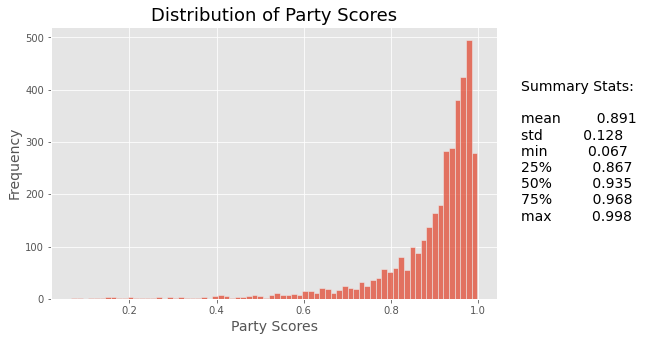

In [319]:
party.dist_viz()

As expected, a catalog of DJ songs have high party scores.

Top 5 party songs

In [321]:
party.top_songs( n = 5)

,title,artist,party
sid,,,
df1eef61a190ffdb618f02d1c87549ed,Khemir - Curacao - I Feel Good ( Khemir Edit )_PN,None,0.9984
8e0500d1bb8c7e5b0e0645ca46480a1b,Have A Cigar,Funk Hunk,0.9982
240ca54e4e0f239acb4705e9cef89a5d,1-Rachel_Wallace_-_Tell_Me_Why_(M_M_full_vocal)_PN,None,0.9979
3746f02034387a50e5768211a47d055d,Act of Sedition - Tropical Punch - 03 The Peanut Man - DJ Laurel edit,None,0.9977
e6debbd0378e989db281d7a284724553,Moving Still - Ouddy Bangers Vol.1 - 01 Cheb Arab - Lo Kan (Moving Still Edit)_PN,None,0.9973


1. [Khemir - Curacao - I Feel Good ( Khemir Edit )_PN](https://www.youtube.com/watch?v=RKU_lCTmVPY&ab_channel=OOUKFunkyOO)

2. [Have A Cigar - Funk Hunk](https://www.youtube.com/watch?v=apmgqyHiy6c&ab_channel=SpaInDiscoRecords%2FFranDeeper)

3. [Rachel_Wallace_-_Tell_Me_Why_(M_M_full_vocal)](https://www.youtube.com/watch?v=YIhF8Y5HIhk&ab_channel=markovnottz)

4. [Act of Sedition - Tropical Punch - 03 The Peanut Man - DJ Laurel edit](https://actofsedition.bandcamp.com/track/the-peanut-man)

5. [Moving Still - Ouddy Bangers Vol.1 - 01 Cheb Arab - Lo Kan (Moving Still Edit](https://soundcloud.com/movingstill/cheb-arab-lo-kan-moving-still-edit)

Top 5 least party songs

In [322]:
party.top_songs(ascending=True, n = 5)

,title,artist,party
sid,,,
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.0666
b0d7c43db439b938a22f246358181549,Ada,Issam Hajali,0.0711
e362351a9985df90496202e75a96d5e2,She Africa (Ton Tour Viendra),N'Draman Blintch,0.0864
48c75551e75efc744602b9784bc10aeb,She,Those Guys From Athens,0.1092
b85f2a4c63f48e712284262c7ff6ffbd,Automation - Workings Of A Madman Re-Mix,Tiny Magnetic Pets,0.1127


1. [Lord Have Mercy - The Lijadu Sisters](https://www.youtube.com/watch?v=cYDwE9yFB_I&ab_channel=TheLijaduSisters-Topic)


2. [Ada Issam Hajali](https://soundcloud.com/habibifunk/issam-hajali-ada-lebanon-1976)


3. [She Africa (Ton Tour Viendra) - N'Draman Blintch](https://www.youtube.com/watch?v=BcvC0UIsINI&ab_channel=Secousse)


4. [She	Those Guys From Athens](https://tooslowtodisco.bandcamp.com/track/she)


5. [Automation - Workings Of A Madman Re-Mix	Tiny Magnetic Pet](https://www.youtube.com/watch?v=X4I4LU04iCo&ab_channel=TinyMagneticPets-Topic)


Sampling party songs between 0.6 and 0.8

In [323]:
party.song_sampler(window=(0.6, 0.8), n=5)

,title,artist,mean scores,stdev scores
sid,,,,
d6b88c709d177924f36560984683ced9,Loxo Nye (Pushin Wood Edit),Roger Damawuzan,0.7900,0.1746
0d594dce5caaaf6d9febfe26156f791d,Masti Bhara Sama Hai (Turbotito & Ragz Rework),"Mangal Singh, Turbotito, Ragz",0.7117,0.2171
aba0580fcbe0956a741c36d72736c6d2,Mistura de Ciranda e Carimbo (iZem Tropical Discoteq fix) _PN,Pinduca,0.6473,0.3690
e0c2d950c952d1f0ddc1e4e63ba3447b,Jose Padilla - Day One (Release Date Vinyl/Digital - 23rd March),International Feel,0.6396,0.2500
cbaefe280340e75156befdc9d32f224a,Þú & Ég - Dans dans dans-T2CnE0x_qYg,None,0.6182,0.2799


1. [Loxo Nye Pushin Wood Edit](https://www.youtube.com/watch?v=OguN00MIBzk&ab_channel=RogerDamawuzan-Topic)

2. [Masti Bhara Sama Hai (Turbotito & Ragz Rework)	Mangal Singh, Turbotito, Ragz](https://www.youtube.com/watch?v=H83IbtyRaFg&ab_channel=MangalSingh-Topic)


3. [Mistura de Ciranda e Carimbo (iZem Tropical Discoteq fix) Pinduca](https://soundcloud.com/izemsounds/pinduca-mistura-de-carimbo-com-ciranda-izems-tropical-discoteq-special-fix)

4. [Jose Padilla - Day One - International Feel](https://www.youtube.com/watch?v=jUQyglvql5Q&ab_channel=Internationalfeel1)

5. [Pu & Eg Dans Dans Dans](https://www.youtube.com/watch?v=T2CnE0x_qYg&t=157s&ab_channel=JohannHelgason)

### Sad

I'm curious to see if sad as any value beyond negatively correlating with happiness

More info => https://essentia.upf.edu/models.html#id531

In [56]:
sad = ActivationDataHub(tables[-1])

Loading mood_sad_effnet_discogs_1_activations data


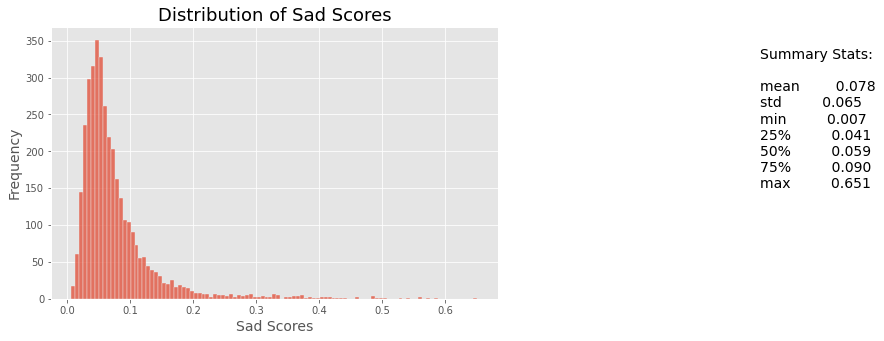

In [325]:
sad.dist_viz()

Top 5 saddest songs

In [326]:
sad.top_songs(n= 5)

,title,artist,sad
sid,,,
3c3f186cb9b2dd15804bf3995b65a34d,Lord Have Mercy,The Lijadu Sisters,0.6513
250592fdef076e436c1853f64633eaa2,Labi Siffre - I got the (Sir Vinyls extended edit),Sir Vinyl Instinct,0.5858
157fd433432aa91f444e115d150e4da0,Fleetwood Mac - Dreams (DJ Son Edit),DJ Son,0.5748
e362351a9985df90496202e75a96d5e2,She Africa (Ton Tour Viendra),N'Draman Blintch,0.5634
b0d7c43db439b938a22f246358181549,Ada,Issam Hajali,0.5609


1. [Lord Have Mercy - The Lijadu Sisters](https://www.youtube.com/watch?v=cYDwE9yFB_I&ab_channel=TheLijaduSisters-Topic)

2. [Labi Siffre - I got the (Sir Vinyls extended edit)	](https://sirvinylinstinct.bandcamp.com/track/labi-siffre-i-got-the-sir-vinyls-extended-edit)

3. [Fleetwood Mac - Dreams (DJ Son Edit)](https://www.youtube.com/watch?v=qSiJKW1-jq8&ab_channel=DJSon)

4. [She Africa (Ton Tour Viendra) - N'Draman Blintch](https://www.youtube.com/watch?v=BcvC0UIsINI&ab_channel=Secousse)

5. [Ada Issam Hajali](https://soundcloud.com/habibifunk/issam-hajali-ada-lebanon-1976)

Even though these are 5 saddest songs in my database, they are moderately sad on average according to the model. However, I'm not really see how they could be considered sad. We're seeing mentions of songs such as Lord Have Mercy (top 5 least party, most acoustic), She Africa (top 5 least party), and Ada (top 5 least party). 

I'm also perplexed at how Dreams (DJ Son edit) could be considered sad. Remember that the model doesn't evaluate the lyrics, which if it did would justify its high sadness score.

Let's further examine this song in particular to see which parts of the song the model rates as highest on the sadness scale

In [327]:
#Grab the array of sad scores for Dreams (DJ Son edit)
dreams_id = '157fd433432aa91f444e115d150e4da0'
sad_dreams = sad.df.loc[dreams_id].sad
sad_dreams[:10]

array([0.5375155 , 0.4181074 , 0.43601257, 0.73205423, 0.75721335,
       0.78875804, 0.80084085, 0.83552885, 0.81524384, 0.8079525 ],
      dtype=float32)

Let's visualize Dream's sad scores throughout the song's progression.

Text(0, 0.5, 'Sad Score')

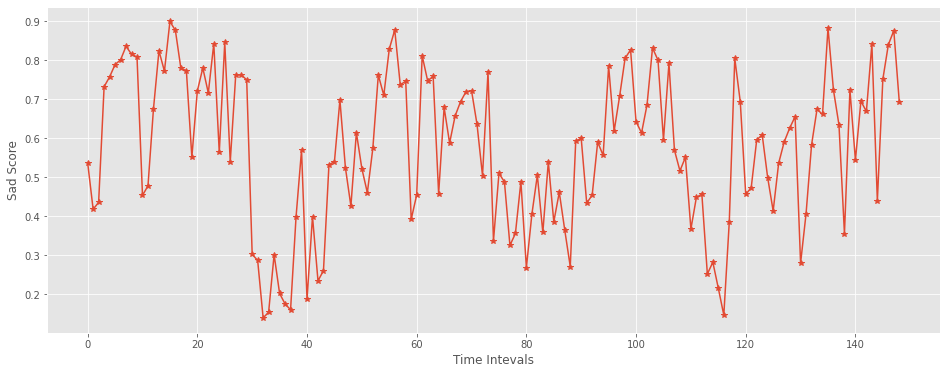

In [328]:
plt.figure(figsize=(16, 6))
x_vals = range(len(sad_dreams))
plt.plot(x_vals, sad_dreams, "-*")
plt.xlabel("Time Intevals")
plt.ylabel("Sad Score")
# plt.grid(False);

It appears that sadness peaks in several windows. Let's pick several of these peaks and give them the ear test.

Now remember that a time interval is equivalent to 2.05 seconds. So we need to convert these interval values to seconds.

In [329]:
seconds = 2.05

#Saddness intervals 
sad_interval1 = (12*seconds, 19*seconds)
sad_interval2 = (53*seconds, 59*seconds)
sad_interval3 = (132*seconds, 138*seconds)

In [330]:
print(sad_interval1)
print(sad_interval2)
print(sad_interval3)

(24.599999999999998, 38.949999999999996)
(108.64999999999999, 120.94999999999999)
(270.59999999999997, 282.9)


Here are three clips from the song starting at various times in the song. Listen for about 12-14 seconds and assess for yourself if evoke sadness.

Interval1: https://youtu.be/qSiJKW1-jq8?t=24 


Interval2: https://youtu.be/qSiJKW1-jq8?t=108


Interval3: https://youtu.be/qSiJKW1-jq8?t=270

Still not convinced that these could sections of the song have a strong case of qualifying as sad. They're certainly mellow and at least for me induce feelings of relaxation and wavviness.

**Random samples**

Five randomly sampled songs with sad scores between 0.1 and 0.3

In [337]:
sad.song_sampler((.1, .3), n = 5, rs = 5)

,title,artist,mean scores,stdev scores
sid,,,,
f34bbce6d615a660ef130647d9081d2c,I'M Feeling Sexy Tonight,Chona Cruz,0.2405,0.1294
e8796c04b3f8297d8c319b767d212442,Meridian Brothers - Guaracha U.F.O (Sibu & Joe Nagall edit),Sibu,0.1993,0.0926
990e7d2ea4685390a3cac5b67dd370d2,Selected Edits Vol 2 - 01 Diskoria,Midnight Runners,0.1583,0.0937
ac76d5b08dc4d68496583d99a183aa2e,Never Never Gonna Give You Up (Refel T. Edit)_PN,Barry White,0.1271,0.0661
50345b72d25e46fc48595bac3111f32a,Nermin Niazi - Feisal Mosleh - Moving Still - Disco Se Aagay- Edits and Reprises - 03 Dekha Jab ...,None,0.1217,0.0814


1. [I'm Feeling Sexy Tonight - Chona Cruz](https://www.youtube.com/watch?v=RG57K_9y5Rc&ab_channel=Marc%27sOPMPlaylist)

2. [Meridian Brothers - Guaracha U.F.O (Sibu & Joe Nagall edit)	Sibu](https://soundcloud.com/sibu/meridian-brothers-guaracha-ufo-sibu-joe-nagall-edit)

3. [Selected Edits Vol 2 - 01 Diskoria	Midnight Runners](https://midnightrunners.bandcamp.com/track/diskoria)

4. [Never Never Gonna Give You Up (Refel T. Edit)](https://refel.bandcamp.com/track/barry-white-never-never-gonna-give-you-up-refel-t-edit)

5. [Nermin Niazi - Feisal Mosleh - Moving Still - Disco Se Aagay- Edits and Reprises - 03 Dekha Jab Se Dekha](https://discostan.bandcamp.com/track/dekha-jab-se-dekha)

"I'm Feeling Sexy Tonight" deserves a much lower score. Like "Dreams" I vehemently disagree with its high sadness score. I'm starting to think that "sadness" is not a strong model as the others or that my song collection may not suitable for it.

## Conclusion

Overall, I am satisified with the scores and deem them appropriate for curating a playlist of songs for my gigs. This exercise proved to be useful developing an understanding of how these model evaluate music and forced me to critically assess songs based on a certain mood. 

It's important to remember the limitations of this task such as sorting songs based on averages and judging model quality based on a small sample of songs.

The next notebook is a continuation of this one where I curate songs for certain DJ gig scenarios based on these model scores.